In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from scipy.constants import c

import iminuit 
from iminuit import Minuit, cost
import ROOT

import mplhep as hep
mpl.style.use(hep.style.ATLAS)




Welcome to JupyROOT 6.24/02


    mpl.rcParams['font.size'] = 8
    mpl.rcParams['figure.dpi'] = 200

Analisi per ottenere valore di $\gamma$. Conosciamo la relazione di fit che è $$ I = \alpha\cdot V^{\frac{4\gamma-1}{4\gamma+1}} $$

In [3]:
V, μ_I, σ_I = np.loadtxt('lamp.txt', unpack=True)

def f(V, α, γ):
    return α*(V**((4*γ-1)/(4*γ+1)))

χ2= cost.LeastSquares(V, μ_I, σ_I, model=f)

m_γ = Minuit(χ2, α=1e-2, γ=0.8)
m_γ.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 1.791e+04 (chi2/ndof = 182.7)│              Nfcn = 61               │
│ EDM = 5.43e-08 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ α    │11.9805e-3 │ 0.0027e-3 │            │            │         │         │       │
│ 1 │ γ    │ 877.69e-3 │  0.24e-3  │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───┬─────────────────────┐
│   │         α         γ │
├───┼─────────────────────┤
│ α │  7.22e-12 -6.12e-10 │
│ γ │ -6.12e-10  5.68e-08 │
└───┴─────────────────────┘

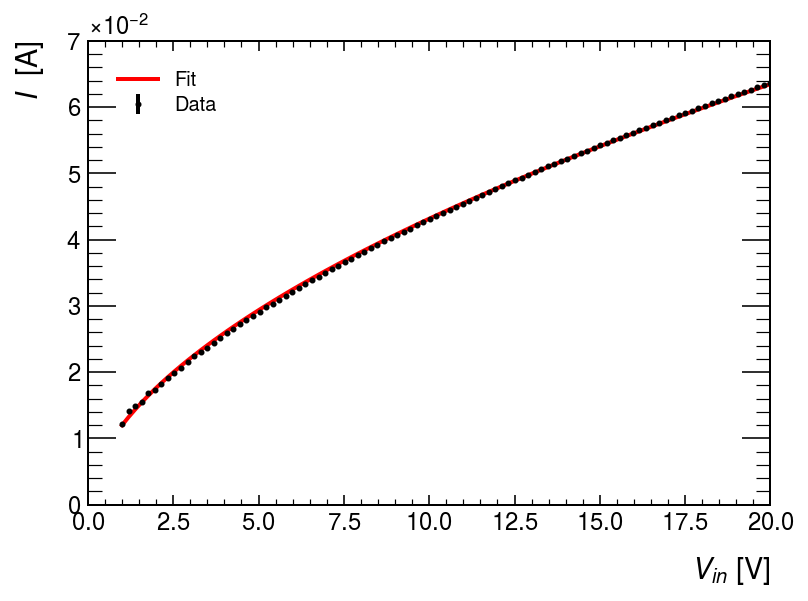

In [4]:
fig, ax = plt.subplots()

ax.set_xlabel('$V_{in}$ [V]')
ax.set_ylabel('$I$  [A]')
ax.errorbar(V, μ_I, σ_I, fmt='k.', markersize=4, label='Data')
ax.plot(V, f(V, *m_γ.values), 'r', label='Fit')
ax.legend()

In [5]:
fig.savefig('../report/fig/gamma_plot.pdf', bbox_inches='tight')

In [6]:
γ, σ_γ = m_γ.values['γ'], m_γ.errors['γ']

from uncertainties import ufloat
print(f'γ = {ufloat(γ, σ_γ):.3uS}')

σ_γ/γ

γ = 0.877687(238)


0.0002715560568118119

$$ T_i = T_{amb} \left(\frac{V_i}{I_i R_{amb}}\right)^\gamma $$

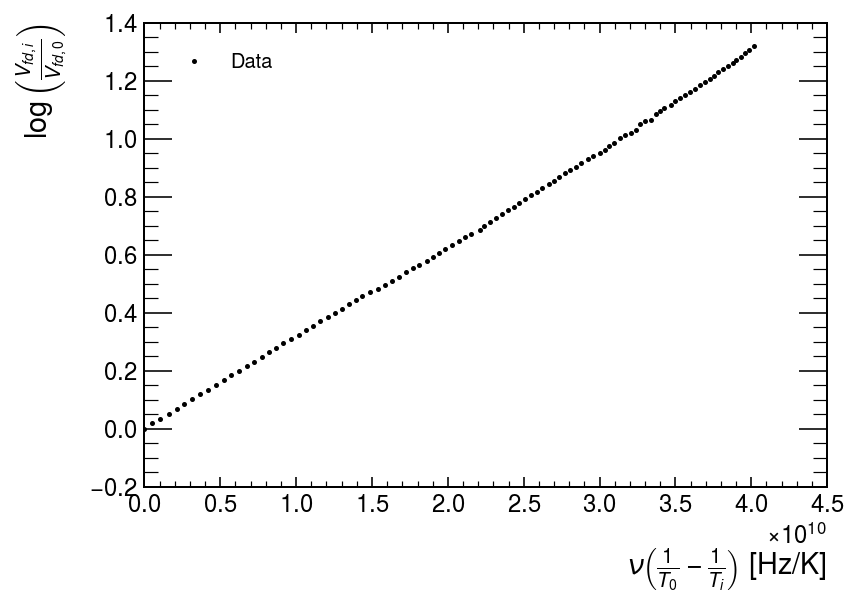

In [26]:
def T(T_amb, R_amb, V, I, γ):
    return T_amb * ( V/(I*R_amb) )**γ


V, μ_I, σ_I, μ_Vfd, σ_Vfd = np.loadtxt('ph_diode.txt', unpack=True)

T_amb = 299.7
σ_T_amb = 0.7
R_amb, σ_R_amb = 25.045, 0.21551350000000002

ν, σ_ν = c/450e-9, c/(450e-9**2) * 10 / (2 * np.log(2 + np.sqrt(3)))

μ_T = T(T_amb, R_amb, V, μ_I, γ)

def log(i, j):
    return np.log(μ_Vfd[i]/μ_Vfd[j])

def Tij(i, j, ν):
    return ν*(1/μ_T[j]-1/μ_T[i])

j: int = 0
LOG = np.array([log(i, j) for i in range(len(μ_Vfd))])
TEMP_DIFF =  np.array([Tij(i, j, ν) for i in range(len(V))])

fig, ax = plt.subplots()
ax.set_xlabel(r'$\nu\left(\frac{1}{T_%d} - \frac{1}{T_i}\right)$ [Hz/K]'%j, labelpad=15)
ax.set_ylabel(r'$\log\left(\frac{V_{fd,i}}{V_{fd,%d}}\right)$'%j)
ax.plot(TEMP_DIFF, LOG, 'k.', markersize=3, label='Data')
ax.legend()

In [38]:
# T(T_amb, R_amb, V, I, γ)

σ_T = np.zeros_like(μ_T)


for i in range(len(σ_T)):
    
    σ2 = 0
    
    σ_T_amb_p = np.abs(T(T_amb + σ_T_amb, R_amb, V[i], μ_I[i], γ) - μ_T[i])
    σ_T_amb_n = np.abs(T(T_amb - σ_T_amb, R_amb, V[i], μ_I[i], γ) - μ_T[i])
    if np.abs(σ_T_amb_n - σ_T_amb_p) < 0.01 * T_amb:
        σ2 += np.max([σ_T_amb_n, σ_T_amb_p])**2
    else:
        print('T_amb: %.5f != %.5f'%(σ_T_amb_n, σ_T_amb_p))

    σ_γ_p = np.abs(T(T_amb, R_amb, V[i], μ_I[i], γ + σ_γ) - μ_T[i])
    σ_γ_n = np.abs(T(T_amb, R_amb, V[i], μ_I[i], γ - σ_γ) - μ_T[i])
    if np.abs(σ_γ_n - σ_γ_p) < (0.01 * γ):
        σ2 += np.max([σ_γ_n, σ_γ_p])**2
    else:
        print('γ:     %.5f != %.5f'%(σ_γ_n, σ_γ_p))
        
    σ_I_p = np.abs(T(T_amb, R_amb, V[i], μ_I[i] + σ_I[i], γ) - μ_T[i])
    σ_I_n = np.abs(T(T_amb, R_amb, V[i], μ_I[i] - σ_I[i], γ) - μ_T[i])
    if np.abs(σ_I_n - σ_I_p) < (0.01 * μ_I[i]):
        σ2 += np.max([σ_I_n, σ_I_p])**2
    else:
        print('μ_I:   %.5f != %.5f'%(σ_I_n, σ_I_p))
    
    σ_R_amb_p = np.abs(T(T_amb, R_amb + σ_R_amb, V[i], μ_I[i], γ) - μ_T[i])
    σ_R_amb_n = np.abs(T(T_amb, R_amb - σ_R_amb, V[i], μ_I[i], γ) - μ_T[i])
    if np.abs(σ_R_amb_n - σ_R_amb_p) < (0.01 * R_amb):
        σ2 += np.max([σ_R_amb_n, σ_R_amb_p])**2
    else:
        print('R_amb: %.5f != %.5f'%(σ_R_amb_n, σ_R_amb_p))

    
    σ_T[i] = np.sqrt(σ2)
    


σ_T


μ_I:   1.30754 != 1.30616
R_amb: 20.06502 != 19.74341
μ_I:   1.30829 != 1.30690
R_amb: 20.10682 != 19.78454
μ_I:   1.30908 != 1.30769
R_amb: 20.14892 != 19.82597
μ_I:   1.30994 != 1.30856
R_amb: 20.19162 != 19.86799
μ_I:   1.31081 != 1.30943
R_amb: 20.23433 != 19.91002
μ_I:   1.31165 != 1.31027
R_amb: 20.27648 != 19.95149
μ_I:   1.31207 != 1.31069
R_amb: 20.31430 != 19.98869
μ_I:   1.31307 != 1.31170
R_amb: 20.35793 != 20.03163
μ_I:   1.31409 != 1.31272
R_amb: 20.40158 != 20.07458
μ_I:   1.31513 != 1.31375
R_amb: 20.44525 != 20.11755
μ_I:   1.31609 != 1.31472
R_amb: 20.48808 != 20.15970
μ_I:   1.31687 != 1.31550
R_amb: 20.52892 != 20.19987
μ_I:   1.31787 != 1.31649
R_amb: 20.57180 != 20.24207
μ_I:   1.31882 != 1.31745
R_amb: 20.61413 != 20.28372
μ_I:   1.31970 != 1.31833
R_amb: 20.65563 != 20.32456
μ_I:   1.32063 != 1.31925
R_amb: 20.69746 != 20.36572
μ_I:   1.32159 != 1.32022
R_amb: 20.73960 != 20.40719
μ_I:   1.32210 != 1.32073
R_amb: 20.77691 != 20.44389
μ_I:   1.32307 != 1.32171
R_

array([6.34876154, 6.36235476, 6.37604722, 6.38993379, 6.4038256 ,
       6.41753448, 6.42983591, 6.4440311 , 6.45823345, 6.47244355,
       6.48638003, 6.49966851, 6.51362467, 6.52740376, 6.54091304,
       6.55452814, 6.56824935, 6.58039497, 6.59405032, 6.6082795 ,
       6.62205633, 6.63584811, 6.64937594, 6.66273394, 6.67620192,
       6.68940846, 6.70272601, 6.71615481, 6.72978789, 6.74242051,
       6.75674095, 6.77154382, 6.78590333, 6.80019061, 6.81394354,
       6.82660853, 6.83985127, 6.85330177, 6.86806815, 6.8809189 ,
       6.89195037, 6.9053128 , 6.9187002 , 6.93220501, 6.94490741,
       6.95708506, 6.97545076, 6.98271794, 6.9952547 , 7.00800338,
       7.02142236, 7.03303718, 7.04495743, 7.05635961, 7.0680677 ,
       7.08072053, 7.09331276, 7.10584483, 7.11895552, 7.13082135,
       7.14199152, 7.15374183, 7.16443476, 7.17698003, 7.18910448,
       7.20326021, 7.21563335, 7.23094544, 7.24184359, 7.25078492,
       7.26157765, 7.27530309, 7.28535465, 7.2988795 , 7.31045

In [28]:
σ_MC = np.zeros_like(σ_T)

def MC_f(R_amb, V, I, γ):
    return ( V / (I * R_amb) )**γ

n_samples = 100_000

rnd = ROOT.TRandom3(2191070958714)

for i in range(len(σ_MC)):
    MC_f_reco = ROOT.TH1D('', '', 100, 0, 0)
    for _ in range(n_samples):
        MC_f_reco.Fill(
            MC_f(
                rnd.Gaus(R_amb, σ_R_amb),
                V[i],
                rnd.Gaus(μ_I[i], σ_I[i]),
                rnd.Gaus(γ, σ_γ)
            )
        )
    σ_MC[i] += MC_f_reco.GetStdDev()





σ_T = np.sqrt(σ_T_amb**2 + σ_MC**2)


In [29]:

μ_Vfd[0], np.max(μ_Vfd), np.max(μ_Vfd)/μ_Vfd[0]



(0.030139, 0.112776, 3.7418627028103124)

$\ln(x)\sim x$ in un intorno di $x$ in [1,3] che sono i valori di interesse

In [30]:
σ_LOG = np.zeros_like(LOG)

def log(Vi, Vj):
    return np.log(Vi/Vj)

def Tij(Ti, Tj, ν):
    return ν*(1/Tj-1/Ti)

for i in range(len(LOG)):
    σ2 = 0.0
    σ_Vi_p = np.abs(log(μ_Vfd[i] + σ_Vfd[i], μ_Vfd[j]) - LOG[i])
    σ_Vi_n = np.abs(log(μ_Vfd[i] - σ_Vfd[i], μ_Vfd[j]) - LOG[i])
    
    if np.abs(σ_Vi_p - σ_Vi_n) < (σ_Vfd[i] / μ_Vfd[i]) * np.max([σ_Vi_p, σ_Vi_n]):
        σ2 += np.max([σ_Vi_p, σ_Vi_n])**2
        # print('Vi %3d: linear! '%i, end='')
    else:
        print('Vi: %.10f != %.10f'%(σ_Vi_n, σ_Vi_p))
    
    σ_Vj_p = np.abs(log(μ_Vfd[i], μ_Vfd[j] + σ_Vfd[j]) - LOG[i])
    σ_Vj_n = np.abs(log(μ_Vfd[i], μ_Vfd[j] - σ_Vfd[j]) - LOG[i])
    
    if np.abs(σ_Vj_p - σ_Vj_n) < (σ_Vfd[j] / μ_Vfd[j]) * np.max([σ_Vj_p, σ_Vj_n]):
        σ2 += np.max([σ_Vj_p, σ_Vj_n])**2
        # print('Vj %3d: linear! '%i, end='')
    else:
        print('Vj: %.10f != %.10f'%(σ_Vj_n, σ_Vj_p))
    
    σ_LOG[i] += np.sqrt(σ2)

Osserviamo che in tutti i casi abbiamo linearità su entrambe le direzioni, quindi possiamo ottenere gli errori sui punti.

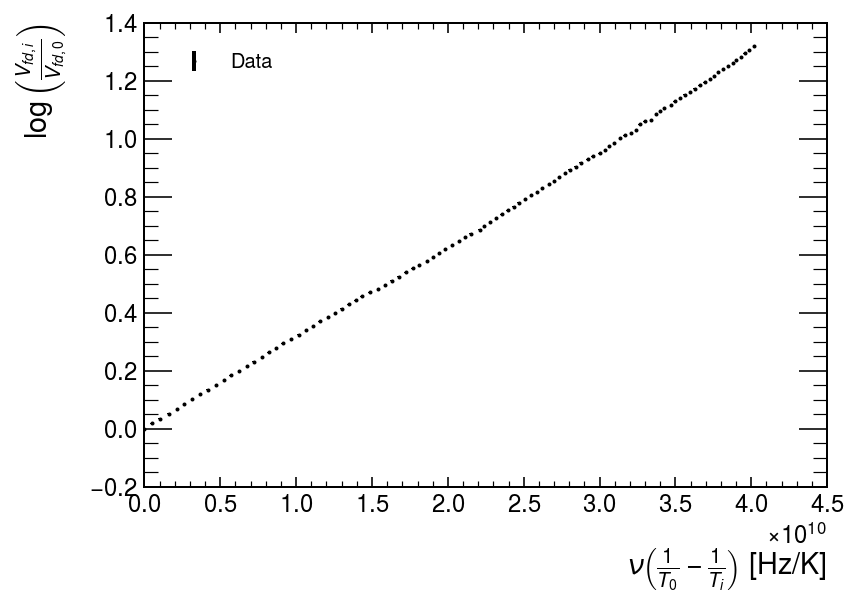

In [31]:
fig, ax = plt.subplots()
ax.set_xlabel(r'$\nu\left(\frac{1}{T_%d} - \frac{1}{T_i}\right)$ [Hz/K]'%j, labelpad=15)
ax.set_ylabel(r'$\log\left(\frac{V_{fd,i}}{V_{fd,%d}}\right)$'%j)
ax.errorbar(TEMP_DIFF, LOG, σ_LOG, color='k', fmt='.', markersize=2, label='Data')
ax.legend()

Dobbiamo ancora calcolare il valore dell'errore che abbiamo invece sul secondo membro (nel caso poi eseguire un plot opposto se vediamo che gli errori sono più importanti)

In [32]:
σ_TEMP_DIFF = np.zeros_like(TEMP_DIFF)

def T0i(T0, Ti, ν):
    return ν*(1/T0-1/Ti)

for i in range(len(TEMP_DIFF)):
    σ2 = 0.0
    σ_T0_p = np.abs(T0i(μ_T[0] + σ_T[0], μ_T[i], ν) - TEMP_DIFF[i])
    σ_T0_n = np.abs(T0i(μ_T[0] - σ_T[0], μ_T[i], ν) - TEMP_DIFF[i])
    
    if np.abs(σ_T0_p - σ_T0_n) < (μ_T[0] / σ_T[0]) * np.max([σ_T0_p, σ_T0_n]):
        σ2 += np.max([σ_T0_p, σ_T0_n])**2
    else:
        print('T0: %.10f != %.10f'%(σ_T0_p, σ_T0_n))
    
    σ_Ti_p = np.abs(T0i(μ_T[0], μ_T[i] + σ_T[i], ν) - TEMP_DIFF[i])
    σ_Ti_n = np.abs(T0i(μ_T[0], μ_T[i] - σ_T[i], ν) - TEMP_DIFF[i])
    
    if np.abs(σ_Ti_p - σ_Ti_n) < (μ_T[i] / σ_T[i]) * np.max([σ_Ti_p, σ_Ti_n]):
        σ2 += np.max([σ_Ti_p, σ_Ti_n])**2
    else:
        print('Ti: %.10f != %.10f'%(σ_Ti_p, σ_Ti_n))
    
    σ_ν_p = np.abs(T0i(μ_T[0], μ_T[i], ν + σ_ν) - TEMP_DIFF[i])
    σ_ν_n = np.abs(T0i(μ_T[0], μ_T[i], ν - σ_ν) - TEMP_DIFF[i])
    
    if np.abs(σ_ν_p - σ_ν_n) < (ν / σ_ν) * np.max([σ_ν_p, σ_ν_n]):
        σ2 += np.max([σ_ν_p, σ_ν_n])**2
    else:
        print('ν : %.30f != %.30f'%(σ_ν_p, σ_ν_n))
    

ν : 0.000000000000000000000000000000 != 0.000000000000000000000000000000


In [33]:
ν

666205462222222.2

In [34]:
σ_ν

5.620743784493845e+21

In [35]:
c

299792458.0